In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import matplotlib.font_manager as fm

from statsmodels.stats.multitest import multipletests

from scipy.cluster.hierarchy import linkage, optimal_leaf_ordering, leaves_list

from itertools import combinations, chain
import upsetplot

import json

import helper

import config
config.config_visuals()

# Define experiments

In [2]:
with open("experiments.json", "r") as f:
    exp = json.load(f)

    experiments = exp["experiments"]
    experiment_ids = exp["experiment_ids"]
    display_names = exp["display_names"]
    display_groups = exp["display_groups"]
    contexts = exp["contexts"]

# Load TPMS and sleuth results

In [3]:
kallisto_sleuth_path = "../data/processed/kallisto_sleuth_merge/"

rpl22_oe_genes = pd.read_hdf(
    kallisto_sleuth_path + "rpl22_oe_genes.h5", key="sleuth_diff"
)
rpl22l1_oe_genes = pd.read_hdf(
    kallisto_sleuth_path + "rpl22l1_oe_genes.h5", key="sleuth_diff"
)
rpl22l1_kd1_genes = pd.read_hdf(
    kallisto_sleuth_path + "rpl22l1_kd1_genes.h5", key="sleuth_diff"
)
rpl22l1_kd2_genes = pd.read_hdf(
    kallisto_sleuth_path + "rpl22l1_kd2_genes.h5", key="sleuth_diff"
)
rpl22_a_ko1_genes = pd.read_hdf(
    kallisto_sleuth_path + "rpl22_a_ko1_genes.h5", key="sleuth_diff"
)
rpl22_a_ko2_genes = pd.read_hdf(
    kallisto_sleuth_path + "rpl22_a_ko2_genes.h5", key="sleuth_diff"
)
rpl22_b_ko1_genes = pd.read_hdf(
    kallisto_sleuth_path + "rpl22_b_ko1_genes.h5", key="sleuth_diff"
)
rpl22_b_ko2_genes = pd.read_hdf(
    kallisto_sleuth_path + "rpl22_b_ko2_genes.h5", key="sleuth_diff"
)

rpl22_oe_transcripts = pd.read_hdf(
    kallisto_sleuth_path + "rpl22_oe_transcripts.h5", key="sleuth_diff"
)
rpl22l1_oe_transcripts = pd.read_hdf(
    kallisto_sleuth_path + "rpl22l1_oe_transcripts.h5", key="sleuth_diff"
)
rpl22l1_kd1_transcripts = pd.read_hdf(
    kallisto_sleuth_path + "rpl22l1_kd1_transcripts.h5", key="sleuth_diff"
)
rpl22l1_kd2_transcripts = pd.read_hdf(
    kallisto_sleuth_path + "rpl22l1_kd2_transcripts.h5", key="sleuth_diff"
)
rpl22_a_ko1_transcripts = pd.read_hdf(
    kallisto_sleuth_path + "rpl22_a_ko1_transcripts.h5", key="sleuth_diff"
)
rpl22_a_ko2_transcripts = pd.read_hdf(
    kallisto_sleuth_path + "rpl22_a_ko2_transcripts.h5", key="sleuth_diff"
)
rpl22_b_ko1_transcripts = pd.read_hdf(
    kallisto_sleuth_path + "rpl22_b_ko1_transcripts.h5", key="sleuth_diff"
)
rpl22_b_ko2_transcripts = pd.read_hdf(
    kallisto_sleuth_path + "rpl22_b_ko2_transcripts.h5", key="sleuth_diff"
)

# Differential expression

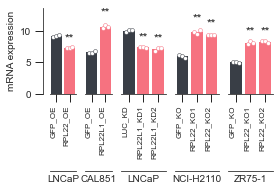

In [4]:
helper.all_bars("ENSG00000163584", "gene")

plt.savefig(
    "../plots/RPL22L1_ENSG00000163584_expression.pdf",
    bbox_inches="tight",
    transparent=True,
)

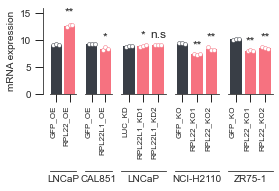

In [5]:
helper.all_bars("ENSG00000116251", "gene")

plt.savefig(
    "../plots/RPL22_ENSG00000116251_expression.pdf",
    bbox_inches="tight",
    transparent=True,
)

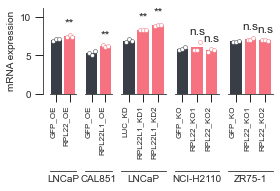

In [6]:
helper.all_bars("ENSG00000135679", "gene")

plt.savefig(
    "../plots/MDM2_ENSG00000135679_expression.pdf",
    bbox_inches="tight",
    transparent=True,
)

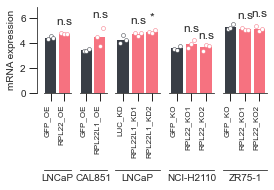

In [7]:
helper.all_bars("ENSG00000198625", "gene")

plt.savefig(
    "../plots/MDM4_ENSG00000198625_expression.pdf",
    bbox_inches="tight",
    transparent=True,
)

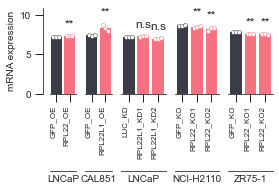

In [8]:
helper.all_bars("ENSG00000143569", "gene")

plt.savefig(
    "../plots/UBAP2L_ENSG00000143569_expression.pdf",
    bbox_inches="tight",
    transparent=True,
)

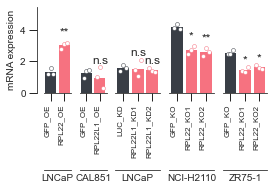

In [9]:
helper.all_bars("ENST00000484819", "transcript")

plt.savefig(
    "../plots/UBAP2L_ENST00000484819_expression.pdf",
    bbox_inches="tight",
    transparent=True,
)

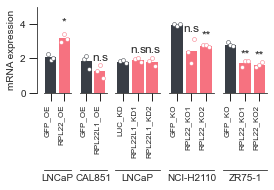

In [10]:
helper.all_bars("ENST00000433615", "transcript")

plt.savefig(
    "../plots/UBAP2L_ENST00000433615_expression.pdf",
    bbox_inches="tight",
    transparent=True,
)

# Overlaps

In [11]:
def get_overlaps(diffs, names, cutoff=0.01, direction=None, filter_empty=True):

    assert len(diffs) == len(names), "Length of diffs and names should match"

    n_diffs = len(diffs)
    all_subset_indices = list(
        chain(*[combinations(range(n_diffs), i) for i in range(1, n_diffs + 1)])
    )

    significants = []

    for diff in diffs:

        if direction == None:

            significant = diff.copy(deep=True)[diff["qval"] < cutoff]

        if direction == "pos":

            significant = diff.copy(deep=True)[diff["qval"] < cutoff]
            significant = significant[significant["treatment_increase"] == 1]

        elif direction == "neg":

            significant = diff.copy(deep=True)[diff["qval"] < cutoff]
            significant = significant[significant["treatment_increase"] == -1]

        significant["gene"] = (
            significant["hgnc_gene"].fillna("nan")
            + "_"
            + pd.Series(significant.index, index=significant.index)
        )

        significant_genes = set(significant["gene"])

        significants.append(significant_genes)

    intersections = []
    intersection_names = []

    for subset_indices in all_subset_indices:

        select_significants = set.intersection(
            *[significants[i] for i in subset_indices]
        )

        if len(subset_indices) < n_diffs:

            select_insignificants = set.union(
                *[significants[i] for i in range(n_diffs) if i not in subset_indices]
            )

            select_significants = select_significants - select_insignificants

        select_names = [names[i] for i in subset_indices]

        intersections.append(select_significants)
        intersection_names.append(select_names)

    intersection_sizes = [len(x) for x in intersections]

    if filter_empty:

        n_subsets = len(intersections)

        empty = [len(x) == 0 for x in intersections]

        intersections = [intersections[i] for i in range(n_subsets) if not empty[i]]
        intersection_names = [
            intersection_names[i] for i in range(n_subsets) if not empty[i]
        ]
        intersection_sizes = [
            intersection_sizes[i] for i in range(n_subsets) if not empty[i]
        ]

    return intersections, intersection_names, intersection_sizes

## Between RPL22L1 shRNAs

In [12]:
rpl22_int_rmats = [
    rpl22_b_ko2_transcripts,
    rpl22_b_ko1_transcripts,
    rpl22_a_ko2_transcripts,
    rpl22_a_ko1_transcripts,
    rpl22_oe_transcripts,
]

rpl22_int_display_names = [
    "ZR75-1 RPL22_KO2",
    "ZR75-1 RPL22_KO1",
    "NCI-H2110 RPL22_KO2",
    "NCI-H2110 RPL22_KO1",
    "LNCaP RPL22_OE",
]

rpl22_ko_ints, rpl22_ko_int_names, rpl22_ko_int_sizes = get_overlaps(
    rpl22_int_rmats, rpl22_int_display_names
)

In [13]:
rpl22_ko_pivot = upsetplot.from_memberships(rpl22_ko_int_names, rpl22_ko_int_sizes)

rpl22_ko_pivot = rpl22_ko_pivot.reorder_levels(rpl22_int_display_names)

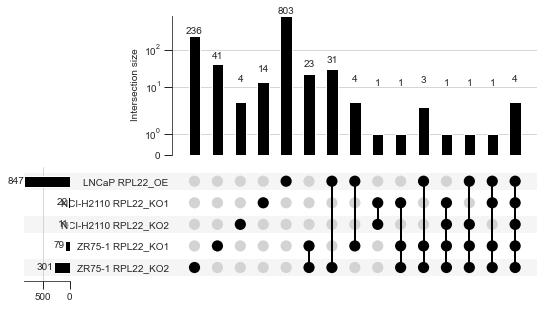

In [14]:
up = upsetplot.plot(rpl22_ko_pivot, sort_categories_by=None, show_counts=True)

up["intersections"].set_yscale("symlog")

# up["intersections"].set_ylim(0.5)

# for patch in up["intersections"]:
#     patch.set_rasterized(True)

plt.savefig(
    "../plots/RPL22_transcript_intersections.pdf",
    transparent=True,
    bbox_inches="tight",
    dpi=25,
)

In [15]:
rpl22l1_int_rmats = [
    rpl22l1_kd2_transcripts,
    rpl22l1_kd1_transcripts,
    rpl22l1_oe_transcripts,
]

rpl22l1_int_display_names = [
    "LNCaP RPL22L1_KD2",
    "LNCaP RPL22L1_KD1",
    "CAL851 RPL22L1_OE",
]

rpl22l1_ko_ints, rpl22l1_ko_int_names, rpl22l1_ko_int_sizes = get_overlaps(
    rpl22l1_int_rmats, rpl22l1_int_display_names
)

In [16]:
rpl22l1_ko_pivot = upsetplot.from_memberships(
    rpl22l1_ko_int_names, rpl22l1_ko_int_sizes
)

rpl22l1_ko_pivot = rpl22l1_ko_pivot.reorder_levels(rpl22l1_int_display_names)

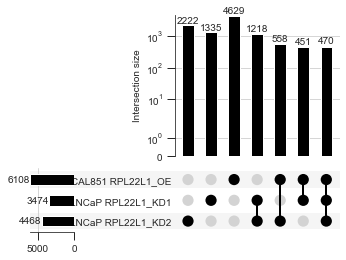

In [17]:
up = upsetplot.plot(rpl22l1_ko_pivot, sort_categories_by=None, show_counts=True)

up["intersections"].set_yscale("symlog")

plt.savefig(
    "../plots/RPL22L1_transcript_intersections.pdf",
    transparent=True,
    bbox_inches="tight",
)

# fgsea results

In [18]:
rpl22_oe_fgsea = pd.read_csv(
    "../data/processed/fgsea_results/rpl22_oe.txt", sep="\t", index_col=0
)
rpl22l1_oe_fgsea = pd.read_csv(
    "../data/processed/fgsea_results/rpl22l1_oe.txt", sep="\t", index_col=0
)
rpl22l1_kd1_fgsea = pd.read_csv(
    "../data/processed/fgsea_results/rpl22l1_kd1.txt", sep="\t", index_col=0
)
rpl22l1_kd2_fgsea = pd.read_csv(
    "../data/processed/fgsea_results/rpl22l1_kd2.txt", sep="\t", index_col=0
)
rpl22_a_ko1_fgsea = pd.read_csv(
    "../data/processed/fgsea_results/rpl22_a_ko1.txt", sep="\t", index_col=0
)
rpl22_a_ko2_fgsea = pd.read_csv(
    "../data/processed/fgsea_results/rpl22_a_ko2.txt", sep="\t", index_col=0
)
rpl22_b_ko1_fgsea = pd.read_csv(
    "../data/processed/fgsea_results/rpl22_b_ko1.txt", sep="\t", index_col=0
)
rpl22_b_ko2_fgsea = pd.read_csv(
    "../data/processed/fgsea_results/rpl22_b_ko2.txt", sep="\t", index_col=0
)


def preprocess_fgsea(fgsea):
    fgsea.sort_values(by="padj", inplace=True)
    fgsea.index = fgsea["pathway"]
    fgsea["gene_set"] = fgsea["pathway"].str.split("_").str[0]
    fgsea["direction"] = fgsea["NES"] > 0


preprocess_fgsea(rpl22_oe_fgsea)
preprocess_fgsea(rpl22l1_oe_fgsea)
preprocess_fgsea(rpl22l1_kd1_fgsea)
preprocess_fgsea(rpl22l1_kd2_fgsea)
preprocess_fgsea(rpl22_a_ko1_fgsea)
preprocess_fgsea(rpl22_a_ko2_fgsea)
preprocess_fgsea(rpl22_b_ko1_fgsea)
preprocess_fgsea(rpl22_b_ko2_fgsea)

# same order as display_names
fgseas = [
    rpl22_oe_fgsea,
    rpl22l1_oe_fgsea,
    rpl22l1_kd1_fgsea,
    rpl22l1_kd2_fgsea,
    rpl22_a_ko1_fgsea,
    rpl22_a_ko2_fgsea,
    rpl22_b_ko1_fgsea,
    rpl22_b_ko2_fgsea,
]

In [170]:
select_names = display_names[:4][::-1]
select_gseas = fgseas[:4][::-1]

top_n = 4

# top gene sets
top_sets = set()

for gsea in select_gseas:

    top = gsea.sort_values(by="pval").head(top_n)
    top = top[top["padj"] < 0.1]
    top = top.index

    top_sets = top_sets | set(top)

set_count = len(top_sets)
top_sets = list(top_sets)

# get top sets for each gsea

merged_top_gsea = []

experiment_coord = 0

for name, gsea in zip(select_names, select_gseas):

    tops = gsea.loc[top_sets]

    tops["experiment"] = name
    tops["experiment_coord"] = experiment_coord
    tops["gene_set_coord"] = range(len(tops))

    experiment_coord += 1
    tops = tops.reset_index(drop=True)

    merged_top_gsea.append(tops)

# merge all the top GSEAS together
merged_top_gsea = pd.concat(merged_top_gsea)
merged_top_gsea = merged_top_gsea.reset_index(drop=True)
merged_top_gsea

# Simplify names
def format_set(x):

    x = x.replace("_", " ")

    x = (
        x.replace("GO ", "")
        .replace(" PROCESS", "")
        .replace(" CONTAINING ", "-")
        .replace(" BINDING", "")
        .replace(" PATHWAY", "")
        .replace(" DEVELOPMENT", " DEV.")
        .replace("REGULATION OF ", "")
        .capitalize()
    )

    return x

merged_top_gsea["pathway"] = merged_top_gsea["pathway"].apply(format_set)

In [171]:
merged_top_gsea["direction"] = merged_top_gsea["direction"].replace(
    {True: "Upregulated", False: "Downregulated"}
)

def get_signed_qval(row):
    if row["direction"] == "Upregulated":
        return -np.log10(row["padj"])
    elif row["direction"] == "Downregulated":
        return np.log10(row["padj"])

merged_top_gsea["signed_qval"] = merged_top_gsea.apply(get_signed_qval, axis=1)

qval_mat = merged_top_gsea[["signed_qval", "pathway", "experiment"]].pivot(
    index="pathway", columns="experiment"
)

# get hierarchical linkage
linkage_mat = linkage(qval_mat, method="ward")
leaf_order = optimal_leaf_ordering(linkage_mat, qval_mat)
ordering = leaves_list(leaf_order)

reordering = dict(zip(list(qval_mat.index[ordering]), range(len(ordering))))

# get coordinates from ordering
# gene_set_coords = list(np.argsort(ordering)) * len(select_names)
# merged_top_gsea["gene_set_coord"] = gene_set_coords

# top_sets = list(np.array(top_sets)[ordering])

merged_top_gsea["gene_set_coord"] = merged_top_gsea["pathway"].map(reordering.get)

In [172]:
set_labels = merged_top_gsea[["pathway","gene_set_coord"]].drop_duplicates(["pathway"])

set_labels = set_labels.sort_values("gene_set_coord")

print("All label positions accounted:", all(set_labels["gene_set_coord"] == range(len(set_labels))))

All label positions accounted: True


(-0.5, 14.5)

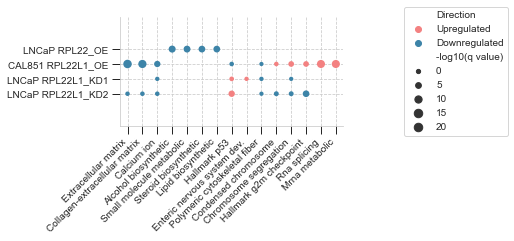

In [173]:
sns.set_style(
    "whitegrid", {"grid.linestyle": "--", "xtick.bottom": True, "ytick.left": True}
)

plt.figure(figsize=(4, 2))
ax = plt.subplot(111)

merged_top_gsea = merged_top_gsea[merged_top_gsea["padj"] < 0.1]

# for i in np.arange(0, len(set_labels), 2)+0.5:
#     ax.axvspan(i-1, i, facecolor='lightgrey', alpha=0.333, zorder=-1)

g = sns.scatterplot(
    merged_top_gsea["gene_set_coord"],
    merged_top_gsea["experiment_coord"],
    size=-np.log10(merged_top_gsea["padj"]).rename("-log10(q value)"),
    hue=merged_top_gsea["direction"].rename("Direction"),
    ax=ax,
    palette={"Downregulated": "#3d84a8", "Upregulated": "#f38181"},
    linewidth=0,
    alpha=1,
)


g.legend(loc="center left", bbox_to_anchor=(1.25, 0.5), ncol=1)

ax.set_yticks(np.arange(len(select_names)))
ax.set_yticklabels(select_names, rotation=0)
ax.set_xticks(set_labels["gene_set_coord"])
ax.set_xticklabels(set_labels["pathway"], rotation=45, ha="right")
# ax.xaxis.tick_top()

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)


# ax.grid(which='major',linestyle='-', linewidth='0.5')

ax.set_xlabel("")
ax.set_ylabel("")

# ax.set_aspect('auto')
plt.axis("equal")

ax.set_ylim(-0.5, len(select_names) - 0.5)
ax.set_xlim(-0.5, len(set_labels) - 0.5)

# plt.savefig("../plots/gsea_summary.pdf", bbox_inches="tight", dpi=512, transparent=True)